In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


DATA_PATH = "./data/Polymer Tg SMILES.xlsx"

data = pd.read_excel(DATA_PATH)
data

,No,Polymer ID,Nama Polimer,SMILES,Tg
0,1,P010001,polyethylene,*C*,-120
1,2,P010002,polypropylene,*CC(C)*,0
2,3,P010003,polybutene,*CC(CC)*,-24
3,4,P010004,poly(pent-1-ene),CCCC(C*)*,-40
4,5,P010008,poly(4-methylpent-1-ene),*CC(CC(C)C)*,30
...,...,...,...,...,...
1435,1436,P522008,"poly(2,2,3,3,4,4,4-heptafluorobutyl 2-fluoroac...",*CC(C(=O)OCC(C(C(F)(F)F)(F)F)(F)F)(F)*,75
1436,1437,P522009,"poly(2,2,3,3,4,4,5,5,5-nonafluoropentyl 2-fluo...",*CC(C(=O)OCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*,63
1437,1438,P522016,"poly(3,3,4,4,5,5,6,6,6-nonafluorohexyl 2-fluor...",*CC(C(=O)OCCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*,6
1438,1439,P522017,"poly(3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluorooc...",*CC(C(=O)OCCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,53


In [2]:
data = data[data["Tg"] != "9,000,00"].copy()
data.reset_index(drop=True, inplace=True)

In [3]:
data["Tg"] = data["Tg"].astype(float)
data["Tg"].describe()

count    1433.00000
mean       85.59187
std        88.82163
min      -139.00000
25%        35.00000
50%        75.00000
75%       130.00000
max       420.00000
Name: Tg, dtype: float64

In [4]:
data["SMILES"].apply(lambda x: len(x)).describe()

count    1439.000000
mean       48.234190
std        27.807956
min         3.000000
25%        28.000000
50%        43.000000
75%        64.000000
max       170.000000
Name: SMILES, dtype: float64

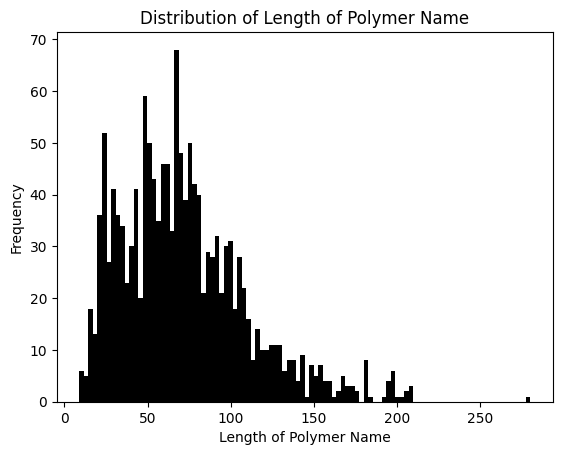

In [5]:
polimer_name_length = data["Nama Polimer"].apply(lambda x: len(x))
polimer_name_length.hist(bins=100, color="#000")
plt.xlabel("Length of Polymer Name")
plt.ylabel("Frequency")
plt.title("Distribution of Length of Polymer Name")
plt.grid(alpha=0)
plt.show()

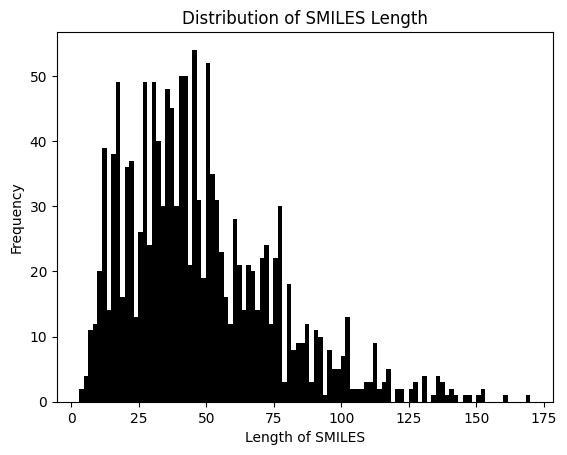

In [6]:
smiles_length = data["SMILES"].apply(lambda x: len(x))
smiles_length.hist(bins=100, color="#000")
plt.xlabel("Length of SMILES")
plt.ylabel("Frequency")
plt.title("Distribution of SMILES Length")
plt.grid(alpha=0)
plt.show()

In [7]:
data["SMILES"]

0                                                     *C*
1                                                 *CC(C)*
2                                                *CC(CC)*
3                                               CCCC(C*)*
4                                            *CC(CC(C)C)*
                              ...                        
1434               *CC(C(=O)OCC(C(C(F)(F)F)(F)F)(F)F)(F)*
1435        *CC(C(=O)OCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*
1436       *CC(C(=O)OCCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*
1437    *CC(C(=O)OCCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...
1438    *CC(C(=O)OCCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...
Name: SMILES, Length: 1439, dtype: object

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs


def preprocess_smiles(smiles_list, max_length=200):
    """
    Preprocess SMILES strings to ensure uniform length and valid format.
    """
    processed_smiles = []

    for smiles in smiles_list:
        # Handle None or missing values
        if not isinstance(smiles, str):
            processed_smiles.append(None)
            continue

        # Remove any problematic characters if needed
        # (This step depends on your specific data)

        # Pad or truncate to max_length
        if len(smiles) < max_length:
            # Pad with spaces to reach max_length
            padded_smiles = smiles.ljust(max_length)
            processed_smiles.append(padded_smiles)
        else:
            # Truncate to max_length
            processed_smiles.append(smiles[:max_length])

    return processed_smiles


# Function to generate molecular fingerprints using RDKit
def generate_fingerprints(smiles_list, fp_size=2048, radius=2):
    """
    Generate Morgan fingerprints (similar to ECFP) for SMILES strings.

    Args:
        smiles_list: List of SMILES strings
        fp_size: Size of the fingerprint bit vector
        radius: Radius for Morgan fingerprint generation

    Returns:
        DataFrame of fingerprint bit vectors
    """
    fingerprints = []
    valid_indices = []

    for i, smiles in enumerate(smiles_list):
        # Skip invalid SMILES
        if not isinstance(smiles, str):
            continue

        try:
            # Convert SMILES to RDKit molecule
            mol = Chem.MolFromSmiles(smiles)

            # Handle parsing failures
            if mol is None:
                # For polymer SMILES with * notation, try replacing with a valid atom
                # This is a simplification - proper polymer handling in RDKit requires more work
                temp_smiles = smiles.replace("*", "C")
                mol = Chem.MolFromSmiles(temp_smiles)
                if mol is None:
                    continue

            # Generate Morgan fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=fp_size)

            # Convert to numpy array
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)

            fingerprints.append(arr)
            valid_indices.append(i)

        except Exception as e:
            print(f"Error processing SMILES {i}: {smiles}")
            print(f"Error: {e}")

    # Convert list of arrays to a single 2D array
    if fingerprints:
        fp_array = np.vstack(fingerprints)
        return pd.DataFrame(fp_array), valid_indices
    else:
        return pd.DataFrame(), []


# Preprocess SMILES strings
data["processed_smiles"] = preprocess_smiles(data["SMILES"].tolist())

# Generate fingerprints
# Note: You may need to adjust parameters based on your requirements


fp_df, valid_indices = generate_fingerprints(data["processed_smiles"].tolist())

# Create feature matrix with only valid molecules
valid_df = data.iloc[valid_indices].copy()
valid_df.reset_index(drop=True, inplace=True)

[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerator
[07:15:20] DEPRECATION WARNING: please use MorganGenerat

In [9]:
fp_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
processed_data = pd.concat([valid_df, fp_df], axis=1)

In [11]:
processed_data = processed_data.dropna(subset=["Tg"])
processed_data.reset_index(drop=True, inplace=True)
processed_data

,No,Polymer ID,Nama Polimer,SMILES,Tg,processed_smiles,0,1,2,3,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,P010001,polyethylene,*C*,-120.0,*C* ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,P010002,polypropylene,*CC(C)*,0.0,*CC(C)* ...,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,P010003,polybutene,*CC(CC)*,-24.0,*CC(CC)* ...,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,P010004,poly(pent-1-ene),CCCC(C*)*,-40.0,CCCC(C*)* ...,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,P010008,poly(4-methylpent-1-ene),*CC(CC(C)C)*,30.0,*CC(CC(C)C)* ...,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,1436,P522008,"poly(2,2,3,3,4,4,4-heptafluorobutyl 2-fluoroac...",*CC(C(=O)OCC(C(C(F)(F)F)(F)F)(F)F)(F)*,75.0,*CC(C(=O)OCC(C(C(F)(F)F)(F)F)(F)F)(F)* ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,1437,P522009,"poly(2,2,3,3,4,4,5,5,5-nonafluoropentyl 2-fluo...",*CC(C(=O)OCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*,63.0,*CC(C(=O)OCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)* ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1427,1438,P522016,"poly(3,3,4,4,5,5,6,6,6-nonafluorohexyl 2-fluor...",*CC(C(=O)OCCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*,6.0,*CC(C(=O)OCCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)*...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428,1439,P522017,"poly(3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluorooc...",*CC(C(=O)OCCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,53.0,*CC(C(=O)OCCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = processed_data.drop(columns=["No", "Polymer ID", "Nama Polimer", "SMILES", "Tg", "processed_smiles"])
y = processed_data["Tg"]

In [14]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
y.head()

0   -120.0
1      0.0
2    -24.0
3    -40.0
4     30.0
Name: Tg, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import xgboost as xgb

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost (best performer according to the paper)
xgb_model = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.15,
    n_estimators=2,  # The paper mentions 2.095, which is unusual - double-check this
    min_child_weight=20,
    gamma=0.0105,
    reg_lambda=0.00719,
    reg_alpha=0.00000247,
)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")

R² score: 0.2155


In [16]:
y = processed_data["Tg"]
y

0      -120.0
1         0.0
2       -24.0
3       -40.0
4        30.0
        ...  
1428     75.0
1429     63.0
1430      6.0
1431     53.0
1432     53.0
Name: Tg, Length: 1433, dtype: float64

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Initialize the regressor
xgb_regressor = XGBRegressor()

# Perform 10-fold cross-validation and evaluate R^2 score
xgb_scores = cross_val_score(xgb_regressor, X, y, cv=10, scoring="r2", n_jobs=-1)

# Print the mean and standard deviation of the R^2 scores
print(f"Mean R^2 score: {xgb_scores.mean():.4f}")
print(f"Standard deviation of R^2 scores: {xgb_scores.std():.4f}")

Mean R^2 score: 0.0116
Standard deviation of R^2 scores: 0.1708
